# Machine Learning Force Field usando VASP, MACE e ASE

Authors: <br>
[Prof. Elvis do A. Soares](https://github.com/elvissoares) <br>
[PhD. Hugo de L. C. Neto](https://github.com/hugo-neto) <br>

Contacts: <br>
[elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/) <br>
[hneto@peq.coppe.ufrj.br](mailto:hneto@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

In [1]:
import os
# Definindo o path para os arquivos de potencial de pseudopotenciais do VASP
# Certifique-se de que o caminho esteja correto para o seu sistema
os.environ['VASP_PP_PATH'] = '/home/elvis/Programs/vasp-6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std'
os.environ['NO_STOP_MESSAGE'] = '1' # to avoid warning from mpirun

# Importando o VASP calculator do ASE
from ase.calculators.vasp import Vasp

from ase.io import write, read
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation

import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

[Foundation models](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) <br>
[MACE](https://mace-docs.readthedocs.io/en/latest/index.html) <br>
[MACE documentation](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) <br>
[Fine tunning](https://mace-docs.readthedocs.io/en/latest/guide/finetuning.html)

## Step 0: Auxiliar function to carry out Molecular Dynamics in ASE

In [ ]:
np.random.seed(701) #fazendo com que os resultados sejam reprodutíveis

# ================================================
# MD ensemble (N,V,T)
# Thermostat: Langevin
# ================================================
# init_conf : obj
#       initial system configuration
# temp : float
#       temperature of the (N,V,T) simulations
# calc : obj 
#       MACE object
# fname : str
#       output name
# s : int
#       print at each frame
# T : int
#       number of frames
# TimeStep : float
#       Time step of the MD
# initTemp : float
#       Initial Temperature
# ================================================
def simpleMD(init_conf, temp, calc, fname, s, T, TimeStep=0.5, initTemp=300, langevin_friction=0.1):
    init_conf.calc = calc

    #initialize the temperature

    MaxwellBoltzmannDistribution(init_conf, temperature_K=initTemp) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn         = Langevin(init_conf, TimeStep*units.fs, temperature_K=temp, friction=langevin_friction) #drive system to desired temperature

    time_fs     = []
    temperature = []
    energies    = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.info['energy_mace']   = dyn.atoms.get_potential_energy()
            dyn.atoms.arrays['forces_mace'] = dyn.atoms.calc.get_forces()
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    plt.savefig("Cellulose_Beta_NPT_300K.png", dpi=300, bbox_inches='tight')
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

## Step 1: Molecular Dynamics using _foundation models_ from MACE

Remember to use kernel in VSCode of 'mlff' (if your conda environment for MACE is mlff)

In [ ]:
from mace.calculators import mace_mp

macemp = mace_mp(model="small", dispersion=True, default_dtype = "float32", device="cuda")

Initial configuration loading and carrying out the MD simulations

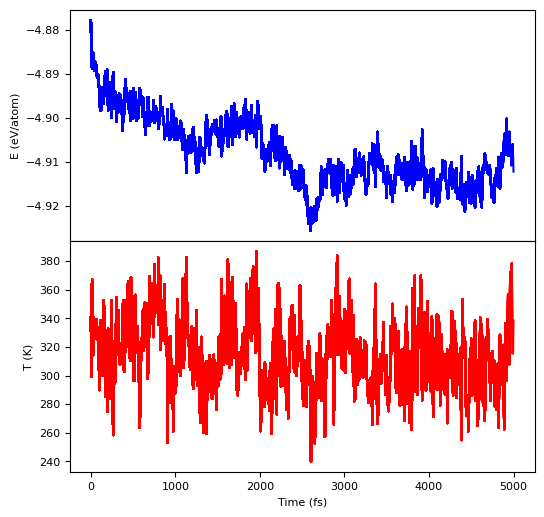

MD finished in 22.76 minutes!


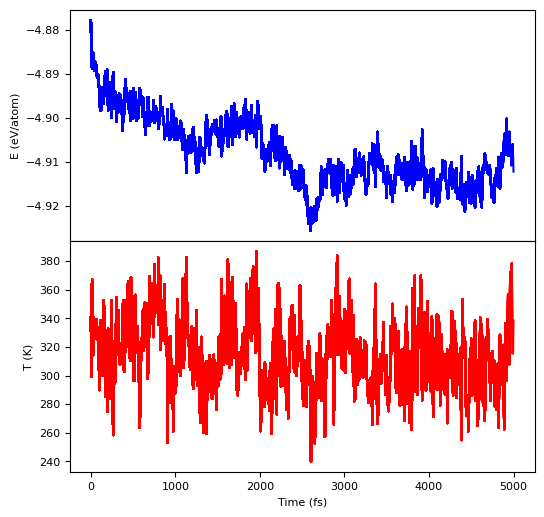

In [ ]:
simu_dir  = "Cellulose_Beta"

init_conf = "Cellulose_Beta.cif"
init_conf = read(os.path.join(os.getcwd(), simu_dir, init_conf)) # It works in Linux and Windows
out_MD    = "Cellulose_Beta_NVT_300K.xyz"
out_MD    = read(os.path.join(os.getcwd(), simu_dir, out_MD))    # It works in Linux and Windows

simpleMD(init_conf, temp=300, calc=macemp, fname=out_MD, s=10, T=80000)

> It took ~X min, compared to XX min of VASP Ab Initio

## Step 2: Comparing the results of energy with Ab Initio calculations of VASP

Creating the Vasp calculator to carry out the single point calculation (SCF): `ibrion=-1`

In [ ]:
simu_dir  = "Cellulose_Beta"
out_vasp  = "Cellulose_Beta_VASP_SCF"
out_vasp  = read(os.path.join(os.getcwd(), simu_dir, out_vasp)) # It works in Linux and Windows

vasp_calc = Vasp(
    directory=out_vasp,
    xc='pbe',
    encut=450,
    kpts=[2, 2, 2], gamma=True,                     # k-points
    ivdw=12, vdw_radius = 50, vdw_cnradius = 20,    # D3(BJ) van der Waals correction
    ismear=0, sigma=0.1,
    ediff=1e-5,       
    isym=0,
    ibrion=-1, nelm=100,                            # single point SCF calculation
    lreal = 'Auto', lwave=False, lcharg=False, lvtot=False
)

Ab Inition calculations to some frames of  `.xyz` file

In [ ]:
from tqdm import tqdm

print("Evaluating MACE configurations with VASP")

traj        = read(out_MD, ':')

periodicity = 10

for at in tqdm(traj[::periodicity]): # Reading every "periodicity" frames to save time
    at.calc                  = vasp_calc
    at.info['energy_vasp']   = at.get_potential_energy()
    at.arrays['forces_vasp'] = at.get_forces()
    at.calc                  = None  #remove calculator to save memory

Evaluating MACE configurations with VASP


100%|██████████| 201/201 [55:22<00:00, 16.53s/it]


> Demorou ~55 minutos para efetuar cálculos de SCF no VASP (aqui não tem AIMD, só SCF)

Storeging the information in a new file but with the recalculated frames

In this new file, we have `energy_mace`, `energy_vasp`, `forces_mace` and `forces_vasp`

In [ ]:
simu_dir  = "Cellulose_Beta"

new_frams = "Cellulose_Beta_NVT_300K_each10.xyz"
new_frams = read(os.path.join(os.getcwd(), simu_dir, new_frams)) # It works in Linux and Windows

write(new_frams, traj[::periodicity]) #save full result

Loading the file to compare the energies. 

Text(0.5, 0, 'Density Prob.')

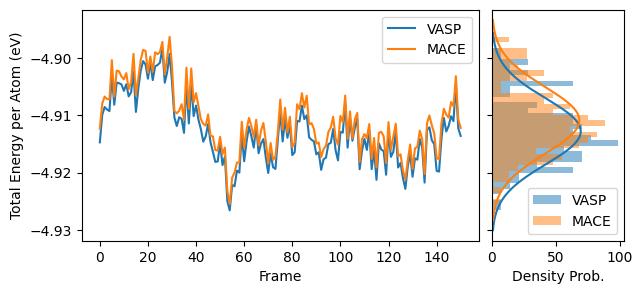

In [ ]:
from aseMolec import extAtoms as ea

traj = read(new_frams, '50:')

frames = np.arange(len(traj))
vasp_energies = ea.get_prop(traj, 'info', 'energy_vasp', peratom=True)
mace_energies = ea.get_prop(traj, 'info', 'energy_mace', peratom=True)

fig, axs = plt.subplots(1, 2,figsize=(7,3), sharey=True, gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.05} )

axs[0].plot(frames, vasp_energies, label='VASP')
axs[0].plot(frames, mace_energies, label='MACE')
axs[0].legend()
axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Total Energy per Atom (eV)')

axs[1].hist(vasp_energies,bins=30,density=True, color='C0', alpha=0.5, label='VASP', orientation="horizontal")
axs[1].hist(mace_energies,bins=30,density=True, color='C1', alpha=0.5, label='MACE', orientation="horizontal")

Umean = np.mean(vasp_energies)
sigmaU = np.std(vasp_energies)
uarray = Umean+np.arange(-3*sigmaU,3*sigmaU,0.01*sigmaU)
axs[1].plot(np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),uarray, color='C0')
Umean = np.mean(mace_energies)
sigmaU = np.std(mace_energies)
uarray = Umean+np.arange(-3*sigmaU,3*sigmaU,0.01*sigmaU)
axs[1].plot(np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),uarray, color='C1')
axs[1].legend()
axs[1].set_xlabel('Density Prob.')

In [ ]:
RMSE = np.sqrt(np.mean((mace_energies-vasp_energies)**2))

print("RMSE between energies of MACE and VASP: {:.3f} eV/átomo".format(RMSE))

RMSE entre energias do MACE e VASP: 0.002 eV/átomo


In [ ]:
vasp_forces = ea.get_prop(traj, 'arrays', 'forces_vasp', peratom=True)
mace_forces = ea.get_prop(traj, 'arrays', 'forces_mace', peratom=True)

RMSE_forces = np.sqrt(np.mean((mace_forces-vasp_forces)**2))

print("RMSE between forces of MACE and VASP: {:.4f} eV/Å".format(RMSE_forces))

RMSE entre forças do MACE e VASP: 0.0005 eV/Å


## Passo 3: Realizando _fine tunning_ da rede MACE

Definindo arquivos para treino e para teste

In [ ]:
import sys
sys.exit(1)

traj = read('mace/mace_md_32h2o_300K_200frames.xyz', ':')
write('mace/mace_md_32h2o_300K_train.xyz', traj[:150])
write('mace/mace_md_32h2o_300K_test.xyz', traj[150:])

Realizando treinamento da rede `MACE` com o foundation model

In [10]:
!mace_run_train \
    --name="finetuned_MACE" \
    --foundation_model="small" \
    --multiheads_finetuning=False \
    --stress_weight=0.0 \
    --forces_weight=1.0 \
    --energy_weight=1.0 \
    --model_dir="mace" \
    --log_dir="mace" \
    --checkpoints_dir="mace" \
    --train_file="mace/mace_md_32h2o_300K_train.xyz" \
    --valid_fraction=0.9 \
    --test_file="mace/mace_md_32h2o_300K_test.xyz" \
    --energy_key="energy_vasp" \
    --forces_key="forces_vasp" \
    --E0s="average" \
    --lr=0.01 \
    --scaling="rms_forces_scaling" \
    --batch_size=2 \
    --max_num_epochs=6 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --default_dtype="float64" \
    --device=cuda \
    --seed=3

/home/elvis/Programs/miniforge3/envs/mlff/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
2025-12-03 11:58:36.882 INFO: ===========VERIFYING SETTINGS===========
2025-12-03 11:58:36.882 INFO: MACE version: 0.3.14
2025-12-03 11:58:36.931 INFO: CUDA version: 12.8, CUDA device: 0
2025-12-03 11:58:37.008 INFO: Using foundation model mace-mp-0 small as initial checkpoint.
Using Materials Project MACE for MACECalculator with /home/elvis/.cache/mace/20231210mace128L0_energy_epoch249model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
/home/elvis/Programs/miniforge3/envs/mlff/lib/python3.10/site-packages/mace/calculators/mace.py:197: UserWarning: Environ

## Passo 5: Usando modelo _fine tunning_

In [11]:
from mace.calculators import MACECalculator

macenew = MACECalculator(model_path="mace/finetuned_MACE.model", device="cuda",default_dtype = "float32")

Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.


/home/elvis/Programs/miniforge3/envs/mlff/lib/python3.10/site-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


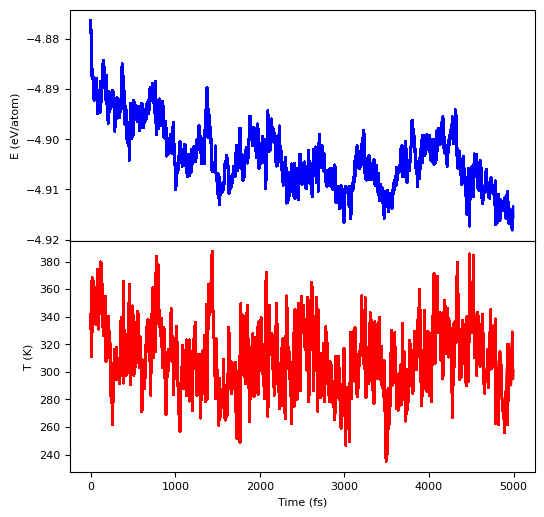

MD finished in 15.06 minutes!


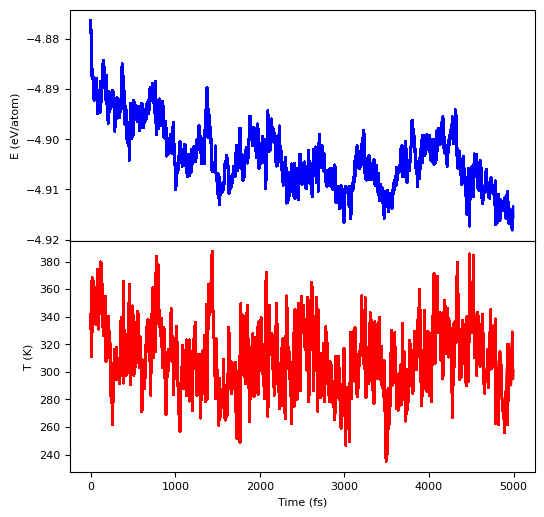

In [12]:
init_conf = read('mace/ic_32h2o_300K.pdb')

np.random.seed(701)

simpleMD(init_conf, temp=300, calc=macenew, fname='mace/mymace_md_32h2o_300K.xyz', s=10, T=10000)